In [18]:
suppressMessages(library(Seurat))
suppressMessages(library(cowplot))
suppressMessages(library(ggplot2))
suppressMessages(library(dplyr))
suppressMessages(library(harmony))
suppressMessages(library(ArchR))

In [19]:
out_dir <- "../../results/10_stereo_seq/06_integrate_with_scrna"

if(!dir.exists(out_dir)){
    dir.create(out_dir)
}

In [20]:
obj.rna <- readRDS("../../results/03_integrate_scrna/integrated.rds")

In [21]:
obj.rna

An object of class Seurat 
15275 features across 95898 samples within 1 assay 
Active assay: RNA (15275 features, 0 variable features)
 1 layer present: counts
 3 dimensional reductions calculated: pca, harmony, umap

In [22]:
obj.rna <- RunUMAP(obj.rna, 
                   reduction = "harmony", dims = 1:30, 
                   reduction.name = "umap_harmony", verbose = FALSE,
                   return.model = TRUE)

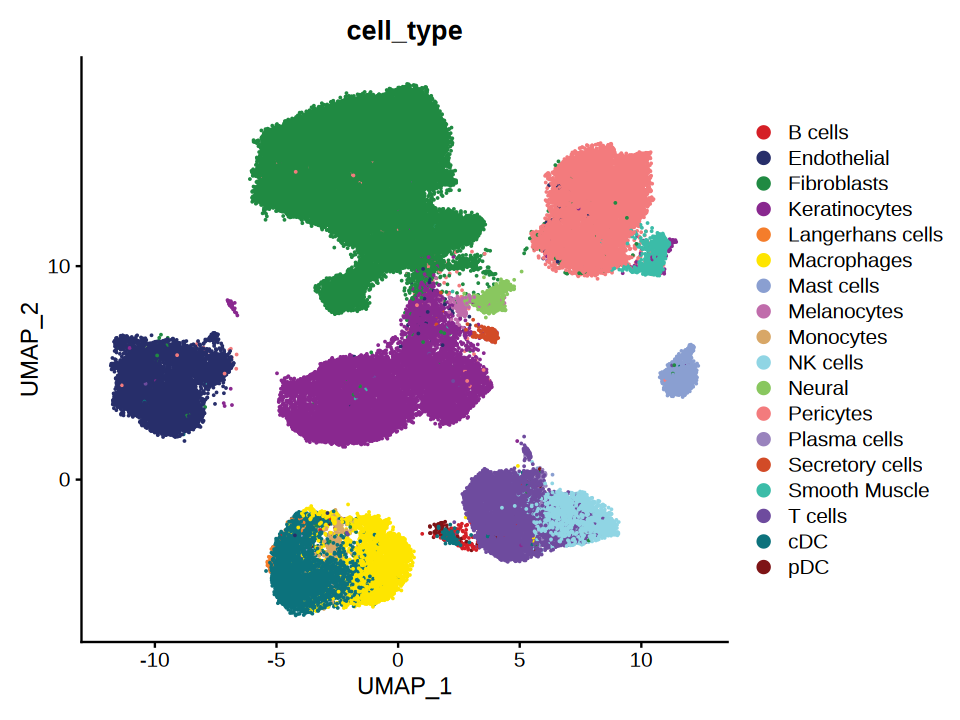

In [23]:
options(repr.plot.height = 6, repr.plot.width = 8)

cols <- ArchR::paletteDiscrete(obj.rna@meta.data$cell_type)

DimPlot(obj.rna, reduction = "umap", group.by = "cell_type", cols = cols)

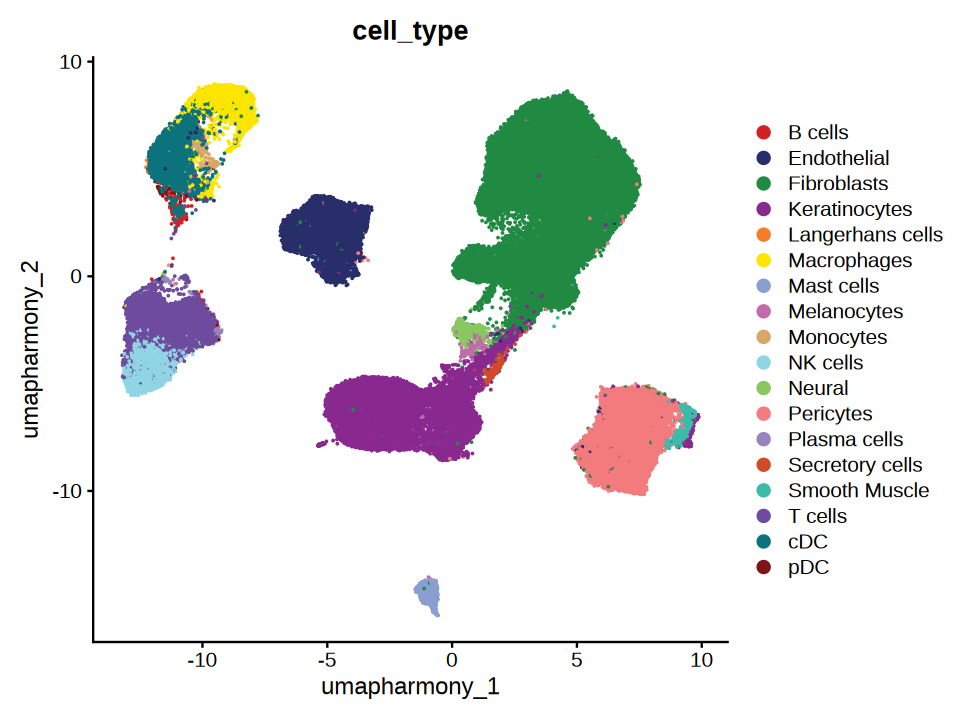

In [24]:
options(repr.plot.height = 6, repr.plot.width = 8)

DimPlot(obj.rna, reduction = "umap_harmony", group.by = "cell_type", cols = cols)

In [25]:
obj.spatial <- readRDS("../../results/10_stereo_seq/05_anndata_to_seurat/integrated.rds")

In [26]:
obj.spatial

An object of class Seurat 
13649 features across 40566 samples within 1 assay 
Active assay: Spatial (13649 features, 0 variable features)
 1 layer present: counts
 1 image present: image

In [27]:
length(intersect(rownames(obj.rna), rownames(obj.spatial)))

[1] 11110

In [28]:
obj.spatial <- obj.spatial %>%
    NormalizeData() %>%
    FindVariableFeatures() %>%
    ScaleData() %>%
    RunPCA(dims = 1:30, verbose = FALSE) %>%
    RunUMAP(dims = 1:30, verbose = FALSE)

Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix



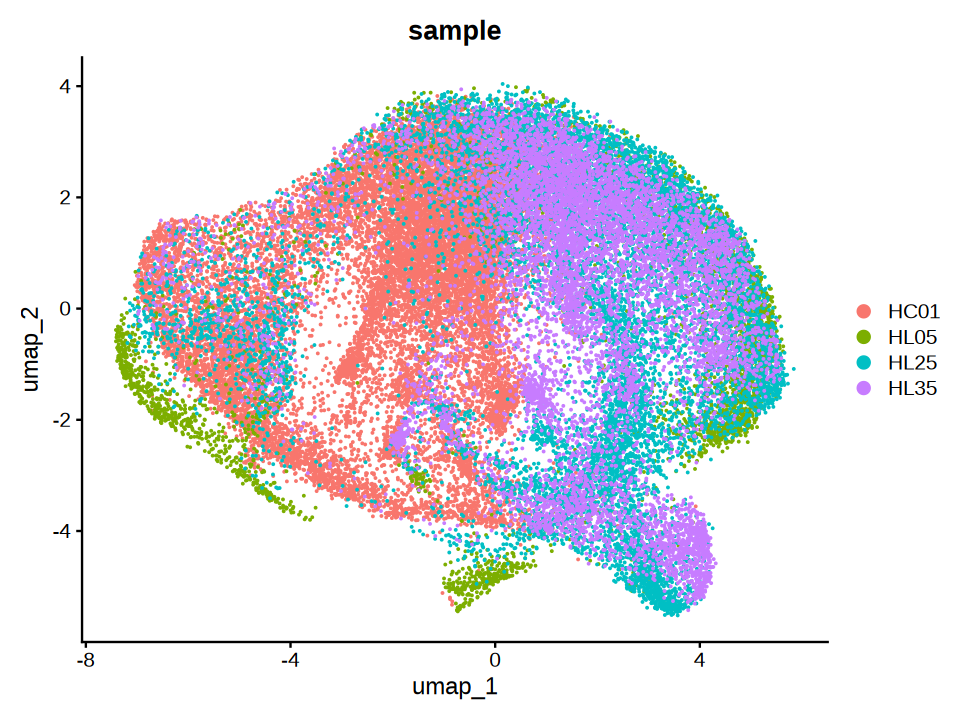

In [29]:
DimPlot(obj.spatial, group.by = "sample")

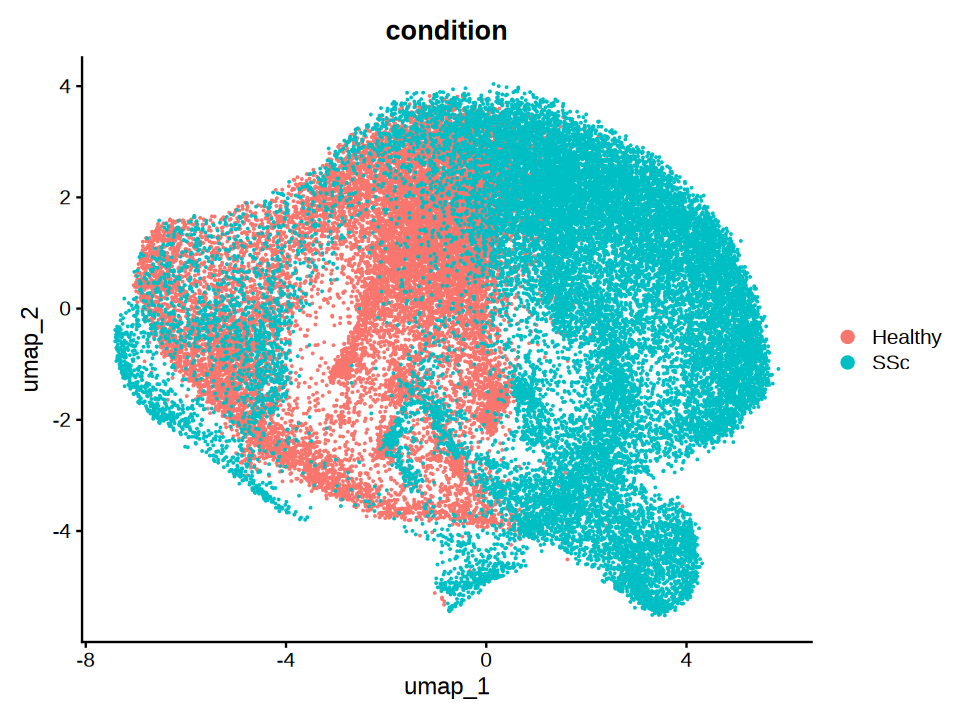

In [30]:
DimPlot(obj.spatial, group.by = "condition")

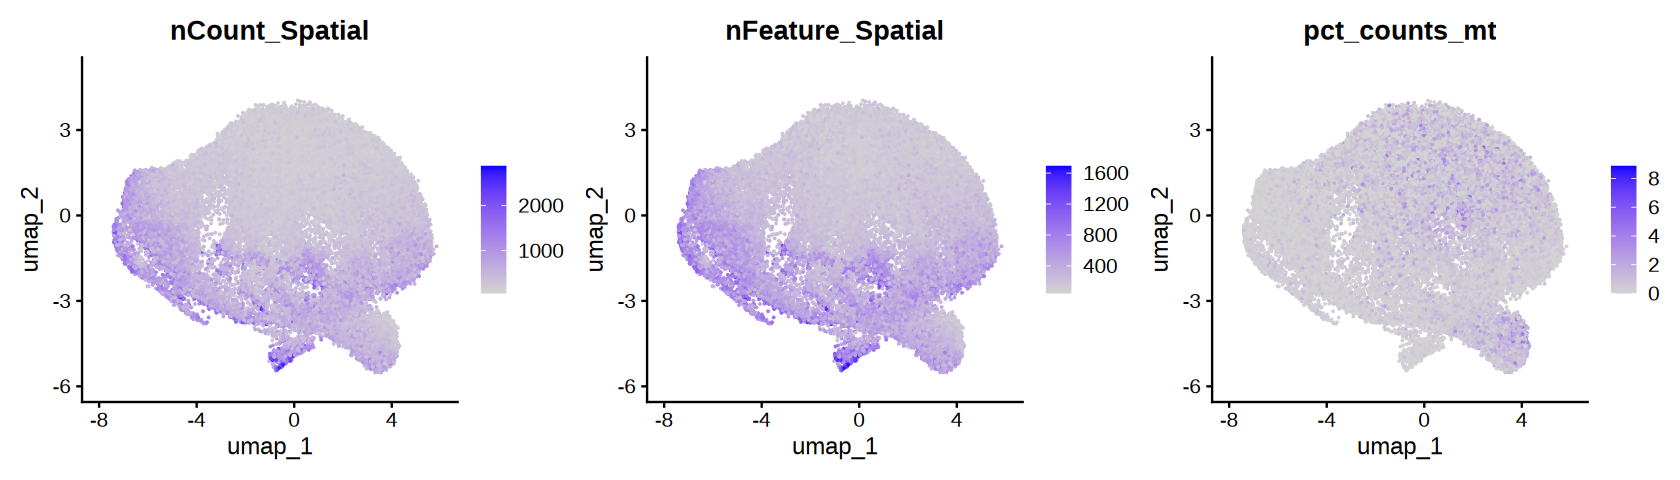

In [31]:
options(repr.plot.height = 4, repr.plot.width = 14)

FeaturePlot(obj.spatial, features = c("nCount_Spatial", "nFeature_Spatial", "pct_counts_mt"), ncol = 3)

In [35]:
obj.spatial

An object of class Seurat 
13649 features across 40566 samples within 1 assay 
Active assay: Spatial (13649 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: pca, umap
 1 image present: image

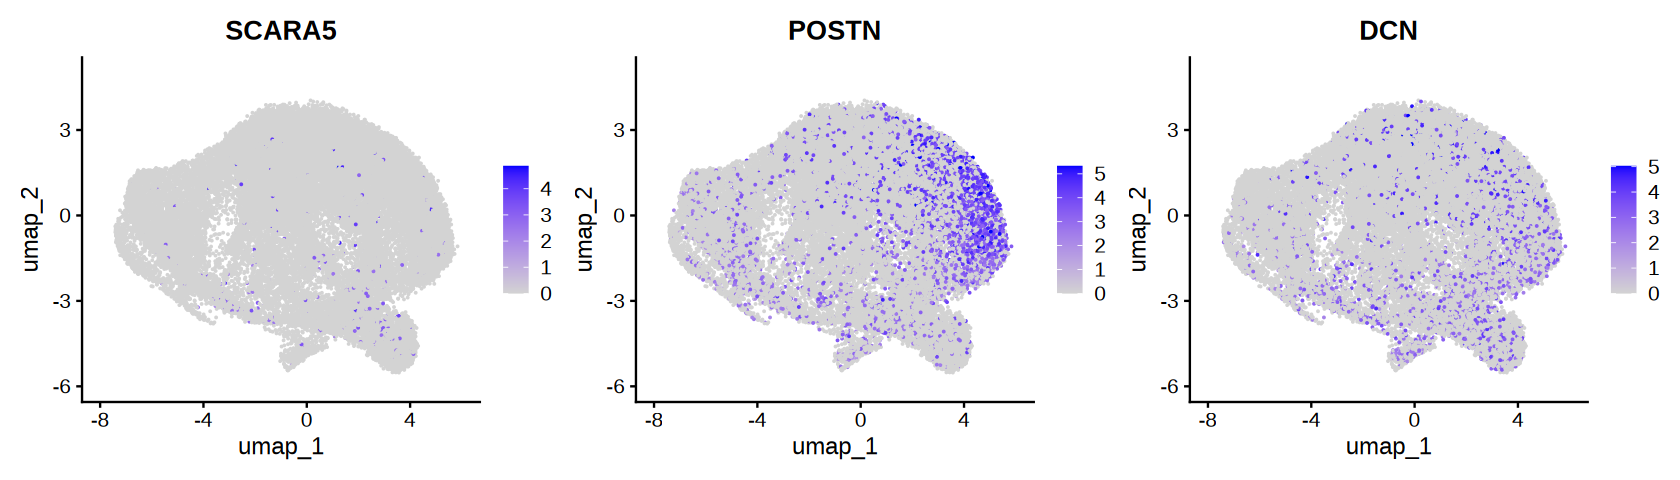

In [37]:
options(repr.plot.height = 4, repr.plot.width = 14)

FeaturePlot(obj.spatial,
            features = c("SCARA5", "POSTN", "DCN"), ncol = 3, max.cutoff = "q99")

In [38]:
obj.rna@meta.data$tech <- "scRNA-seq"
obj.spatial@meta.data$tech <- "Stereo-seq"

In [39]:
obj.merged <- merge(
  x = obj.rna,
  y = obj.spatial,
  merge.data = FALSE,
)

obj.merged[["RNA"]] <- split(obj.merged[["RNA"]], f = obj.merged$tech)

In [40]:
obj.merged

An object of class Seurat 
28924 features across 136464 samples within 2 assays 
Active assay: RNA (15275 features, 0 variable features)
 1 layer present: counts.scRNA-seq
 1 other assay present: Spatial
 1 image present: image

In [ ]:
obj.merged <- obj.merged %>%
    NormalizeData() %>%
    FindVariableFeatures() %>%
    ScaleData() %>%
    RunPCA(dims = 1:30, verbose = FALSE) %>%
    RunUMAP(dims = 1:30, verbose = FALSE)

In [ ]:
options(repr.plot.height = 4, repr.plot.width = 6)

DimPlot(obj.merged, group.by = "tech")

In [ ]:
obj.merged <- IntegrateLayers(object = obj.merged, 
                              method = CCAIntegration, 
                              orig.reduction = "pca", 
                              new.reduction = "integrated.cca",
                              verbose = TRUE)

In [ ]:
# re-join layers after integration
obj.merged[["RNA"]] <- JoinLayers(obj.merged[["RNA"]])
obj.merged <- RunUMAP(obj.merged, dims = 1:30, reduction = "integrated.cca")        

In [ ]:
options(repr.plot.height = 4, repr.plot.width = 6)

DimPlot(obj.merged, group.by = "orig.ident")

In [ ]:
features <- intersect(rownames(obj.rna), rownames(obj.spatial))

In [ ]:
length(features)

In [ ]:
obj.rna

In [ ]:
anchors <- FindTransferAnchors(reference = obj.rna, 
                               query = obj.spatial, 
                               reference.assay = "RNA",
                               query.assay = "RNA",
                               reduction = "cca",
                               features = features,
                               npcs = 30)

In [ ]:
predictions <- TransferData(anchorset = anchors, 
                            refdata = obj.rna$cell_type,
                            weight.reduction = "cca")

In [ ]:
obj.spatial <- AddMetaData(obj.spatial, metadata = predictions)

In [ ]:
head(obj.spatial@meta.data)

In [ ]:
options(repr.plot.height = 6, repr.plot.width = 8)

DimPlot(obj.spatial, group.by = "predicted.id", cols = cols)

In [ ]:
obj.spatial <- IntegrateEmbeddings(anchorset = anchors, 
                                   reference = obj.rna,
                                   query = obj.spatial,
                                   query.assay = "RNA",
                                   reductions = "cca",
                                   new.reduction.name = "ref.pca")

In [ ]:
obj.spatial <- ProjectUMAP(query = obj.spatial, 
                           query.reduction = "ref.pca", 
                           reference = obj.rna,
                           reference.reduction = "harmony", 
                           reduction.model = "umap_harmony")